<a href="https://www.kaggle.com/code/ulyccec/car-detection-with-yolov5-8e54bc?scriptVersionId=122495000" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Importing required packages
* tesnsorflow, numpy, pandas
* cv2 for drawing rectangle on images
* tdqm for showing progress bar
* shutil for copying images

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import os
import random

from tqdm.auto import tqdm
import shutil as sh
from PIL import Image

In [2]:
import wandb
from fastai.callback.wandb import WandbCallback
from kaggle_secrets import UserSecretsClient

In [3]:
# user_secrets = UserSecretsClient()
# secret_value_0 = user_secrets.get_secret("WANDB_API_KEY")
# os.environ["WANDB_API_KEY"] = secret_value_0
# os.environ["WANDB_RUN_GROUP"] = "WANDB-EXAMPLE" # + wandb.util.generate_id() if you want a new random id for each run

In [4]:
# !pip install wandb
# import wandb
# #wandb.login()

# Importing images for training our custom traning set
* **train_dir**: training images 
* **test_dir**: testing images
* **data**: value of boxes co-ordinates on images(xmin,ymin,xmax,ymax)

In [5]:
train_dir = "/kaggle/input/car-object-detection/data/training_images/"
test_dir = "/kaggle/input/car-object-detection/data/testing_images/"

print('Image(train): ', len(os.listdir(train_dir)))
print('Image(test): ', len(os.listdir(test_dir)))

Image(train):  1001
Image(test):  175


In [6]:
data = pd.read_csv("/kaggle/input/car-object-detection/data/train_solution_bounding_boxes (1).csv")

In [7]:
data.head()

image        xmin        ymin        xmax        ymax
0   vid_4_1000.jpg  281.259045  187.035071  327.727931  223.225547
1  vid_4_10000.jpg   15.163531  187.035071  120.329957  236.430180
2  vid_4_10040.jpg  239.192475  176.764801  361.968162  236.430180
3  vid_4_10020.jpg  496.483358  172.363256  630.020260  231.539575
4  vid_4_10060.jpg   16.630970  186.546010  132.558611  238.386422

In [8]:
print(data.shape)
data.nunique()

(559, 5)


image    355
xmin     440
ymin     149
xmax     438
ymax     184
dtype: int64

# Showing training Images with green boxes on car

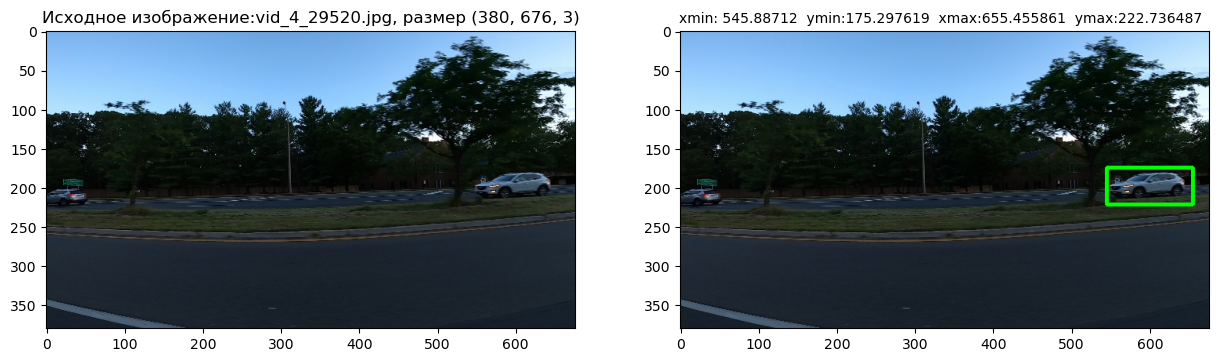

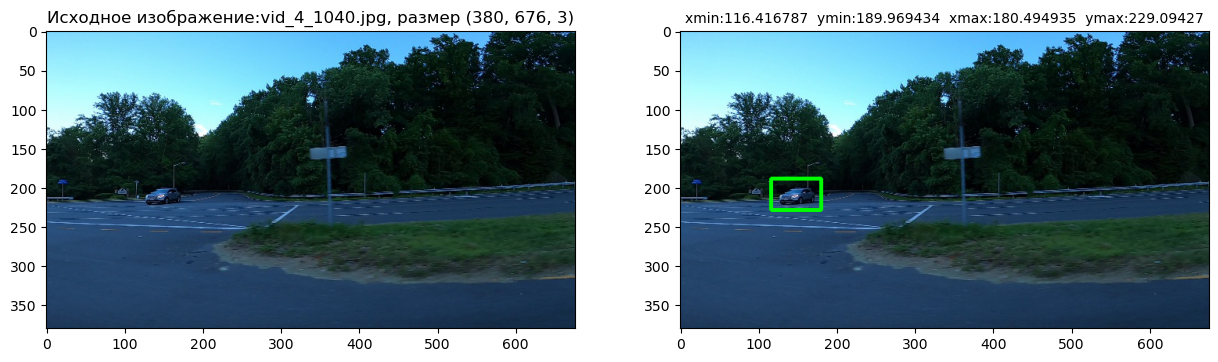

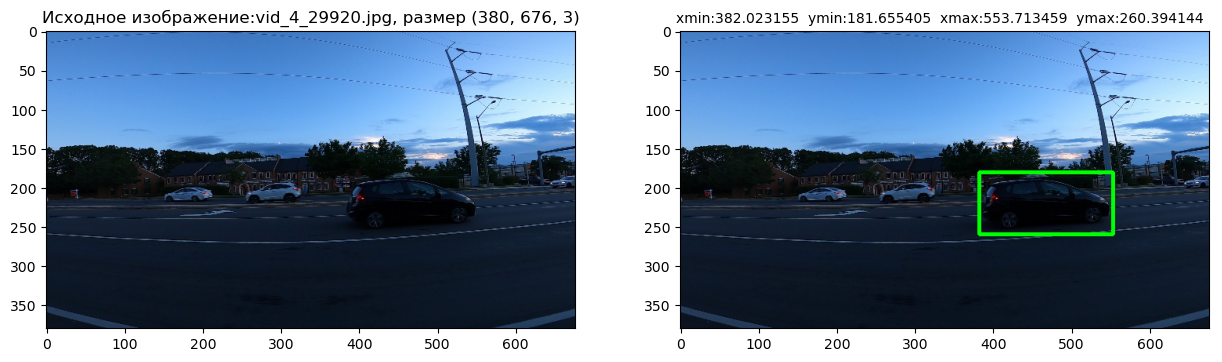

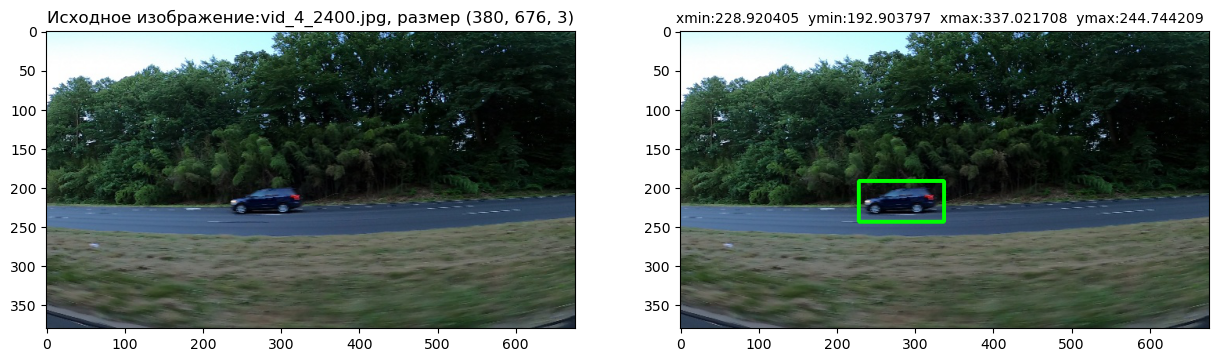

In [9]:
IMAGE_SHAPE = 0
for i in range(4):
    rand = np.random.randint(0, data.shape[0])
    random_row = data.iloc[rand]
    image = plt.imread(train_dir + random_row[0])
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(1, 2, 1)
    plt.imshow(image)
    IMAGE_SHAPE = image.shape
    plt.title(f"Исходное изображение:{random_row[0]}, размер {image.shape}")
    ax = fig.add_subplot(1, 2, 2)
    point1 = (int(random_row[1]), int(random_row[2]))
    point2 = (int(random_row[3]), int(random_row[4]))
    cv2.rectangle(image, point1, point2, color=(0, 255, 0), thickness=3)
    plt.imshow(image)
    s = str(random_row[1:5])[:-24].replace('    ', ':').replace('\n','  ')
    plt.title(f"{s}", fontsize= 10)
    

# Cloning yolov5 from github

**Link:** https://github.com/ultralytics/yolov5 

In [10]:
!git clone https://github.com/ultralytics/yolov5
!cd yolov5
!pip install -r ./yolov5/requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 15305, done.
remote: Total 15305 (delta 0), reused 0 (delta 0), pack-reused 15305
Receiving objects: 100% (15305/15305), 14.19 MiB | 26.95 MiB/s, done.
Resolving deltas: 100% (10500/10500), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.0 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 59.8.0
    Uninstalling setuptools-59.8.0:
      Successfully uninstalled setuptools-59.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask-cudf 21.12.2 requires cupy-cuda115, which is not installed.
cudf 21.12.2 requires cupy-cuda115, which is not installed.
tensorflow 2.11.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.
tensorflow-transform 1.12.0 requires pyarrow<7,>=6, but you have pyarrow 5.0.0 which is incompatib

# Data processing

Converting (xmin,ymin,xmax,ymax) to (x_center,y_center, w, h) as yolo5 required that format.

In [11]:
im_h, im_w, num_chanels = IMAGE_SHAPE
data["x_center"] = (data["xmax"] + data["xmin"])/2
data["y_center"] = (data["ymax"] + data["ymin"])/2
data["w"] = data["xmax"] - data["xmin"]
data["h"] = data["ymax"] - data["ymin"]
data["classes"] = 0
#Normalizing the values with image height and width
data["x_center"] = data["x_center"]/im_w
data["w"] = data["w"]/im_w
data["y_center"] = data["y_center"]/im_h
data["h"] = data["h"]/im_h
data.head()

image        xmin        ymin        xmax        ymax  x_center  \
0   vid_4_1000.jpg  281.259045  187.035071  327.727931  223.225547  0.450434   
1  vid_4_10000.jpg   15.163531  187.035071  120.329957  236.430180  0.100217   
2  vid_4_10040.jpg  239.192475  176.764801  361.968162  236.430180  0.444645   
3  vid_4_10020.jpg  496.483358  172.363256  630.020260  231.539575  0.833213   
4  vid_4_10060.jpg   16.630970  186.546010  132.558611  238.386422  0.110347   

   y_center         w         h  classes  
0  0.539817  0.068741  0.095238        0  
1  0.557191  0.155572  0.129987        0  
2  0.543678  0.181621  0.157014        0  
3  0.531451  0.197540  0.155727        0  
4  0.559122  0.171491  0.136422        0

In [12]:
index = list(data.image)
print(len(index))

559


# Training with yolov5 model

First we are going create a folder "data/fold0" and divide our training images into train and validation set. We are going to create a txt file for each images with box co-ordinates(x_center, y_center, w, h).

**STEP-1: Creating a txt file for each images inside labels folder**

validation set: "data/fold0/labels/val/"

training set: "data/fold0/labels/train/"

**STEP-2: Copying images from each Input to folder**

validation images: "data/fold0/images/val/"

training images: "data/fold0/images/train/"

**STEP-3: Creating dataset.yaml**

Creating a dataset.yaml file as required for custom training the yolov5 model,which contains path to training data and validation data.

**STEP-4: Training the model with custom data**

We are going to train the model with:

    - Batch size = 12
    - Epochs = 12
    - CONF_TRESHOLD = 0.6
    - IOU_THRESHOLD = 0.5
    - MODEL = 'yolov5x.pt' (large model for better output)

In [13]:
if not os.path.exists("data"):
    os.makedirs("data")
    os.makedirs("data/fold{}".format(0))

In [14]:
source = 'training_images'
if True:
    for fold in [0]:
        val_index = index[len(index)*fold//5:len(index)*(fold+1)//5]
        for name,mini in tqdm(data.groupby('image')):
            if name in val_index:
                path2save = 'val/'
            else:
                path2save = 'train/'
            if not os.path.exists('data/fold{}/labels/'.format(fold)+path2save):
                os.makedirs('data/fold{}/labels/'.format(fold)+path2save)
            with open('data/fold{}/labels/'.format(fold)+path2save+name+".txt", 'w+') as f:
                row = mini[['classes','x_center','y_center','w','h']].astype(float).values
                row = row.astype(str)
                for j in range(len(row)):
                    text = ' '.join(row[j])
                    f.write(text)
                    f.write("\n")
            if not os.path.exists('data/fold{}/images/{}'.format(fold,path2save)):
                os.makedirs('data/fold{}/images/{}'.format(fold,path2save))
            sh.copy("/kaggle/input/car-object-detection/data/{}/{}".format(source,name),'data/fold{}/images/{}/{}.jpg'.format(fold,path2save,name))
        print("Copy done")
        print('Image(train): ', len(os.listdir('data/fold0/images/train/')))
        print('Image(test): ', len(os.listdir('data/fold0/images/val/')))

  0%|          | 0/355 [00:00<?, ?it/s]

Copy done
Image(train):  281
Image(test):  74


In [15]:
%%writefile dataset.yaml
path: /kaggle/working/data/fold0
train: /kaggle/working/data/fold0/images/train/
val: /kaggle/working/data/fold0/images/val/
test:

names:
    0: car

Writing dataset.yaml


In [16]:
IMG_SIZE = IMAGE_SHAPE[1]
CONF_TRESHOLD = 0.6
IOU_THRESHOLD = 0.5
MODEL = 'yolov5x.pt'

In [17]:
import time

start = time.perf_counter()

!python yolov5/train.py --batch 12 --epochs 1 --data dataset.yaml --weights {MODEL} --name my_model_5x

end = time.perf_counter()

total_time = end - start

print(f'Training time for {MODEL} model is: {total_time:0.2f} seconds')

wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: (30 second timeout) 
wandb: W&B disabled due to login timeout.
train: weights=yolov5x.pt, cfg=, data=dataset.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=1, batch_size=12, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5/runs/train, name=my_model_5x, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://

In [18]:
!ls yolov5/runs/train/my_model_5x/

F1_curve.png					   results.png
PR_curve.png					   train_batch0.jpg
P_curve.png					   train_batch1.jpg
R_curve.png					   train_batch2.jpg
confusion_matrix.png				   val_batch0_labels.jpg
events.out.tfevents.1679076891.49671451e1f7.104.0  val_batch0_pred.jpg
hyp.yaml					   val_batch1_labels.jpg
labels.jpg					   val_batch1_pred.jpg
labels_correlogram.jpg				   val_batch2_labels.jpg
opt.yaml					   val_batch2_pred.jpg
results.csv					   weights


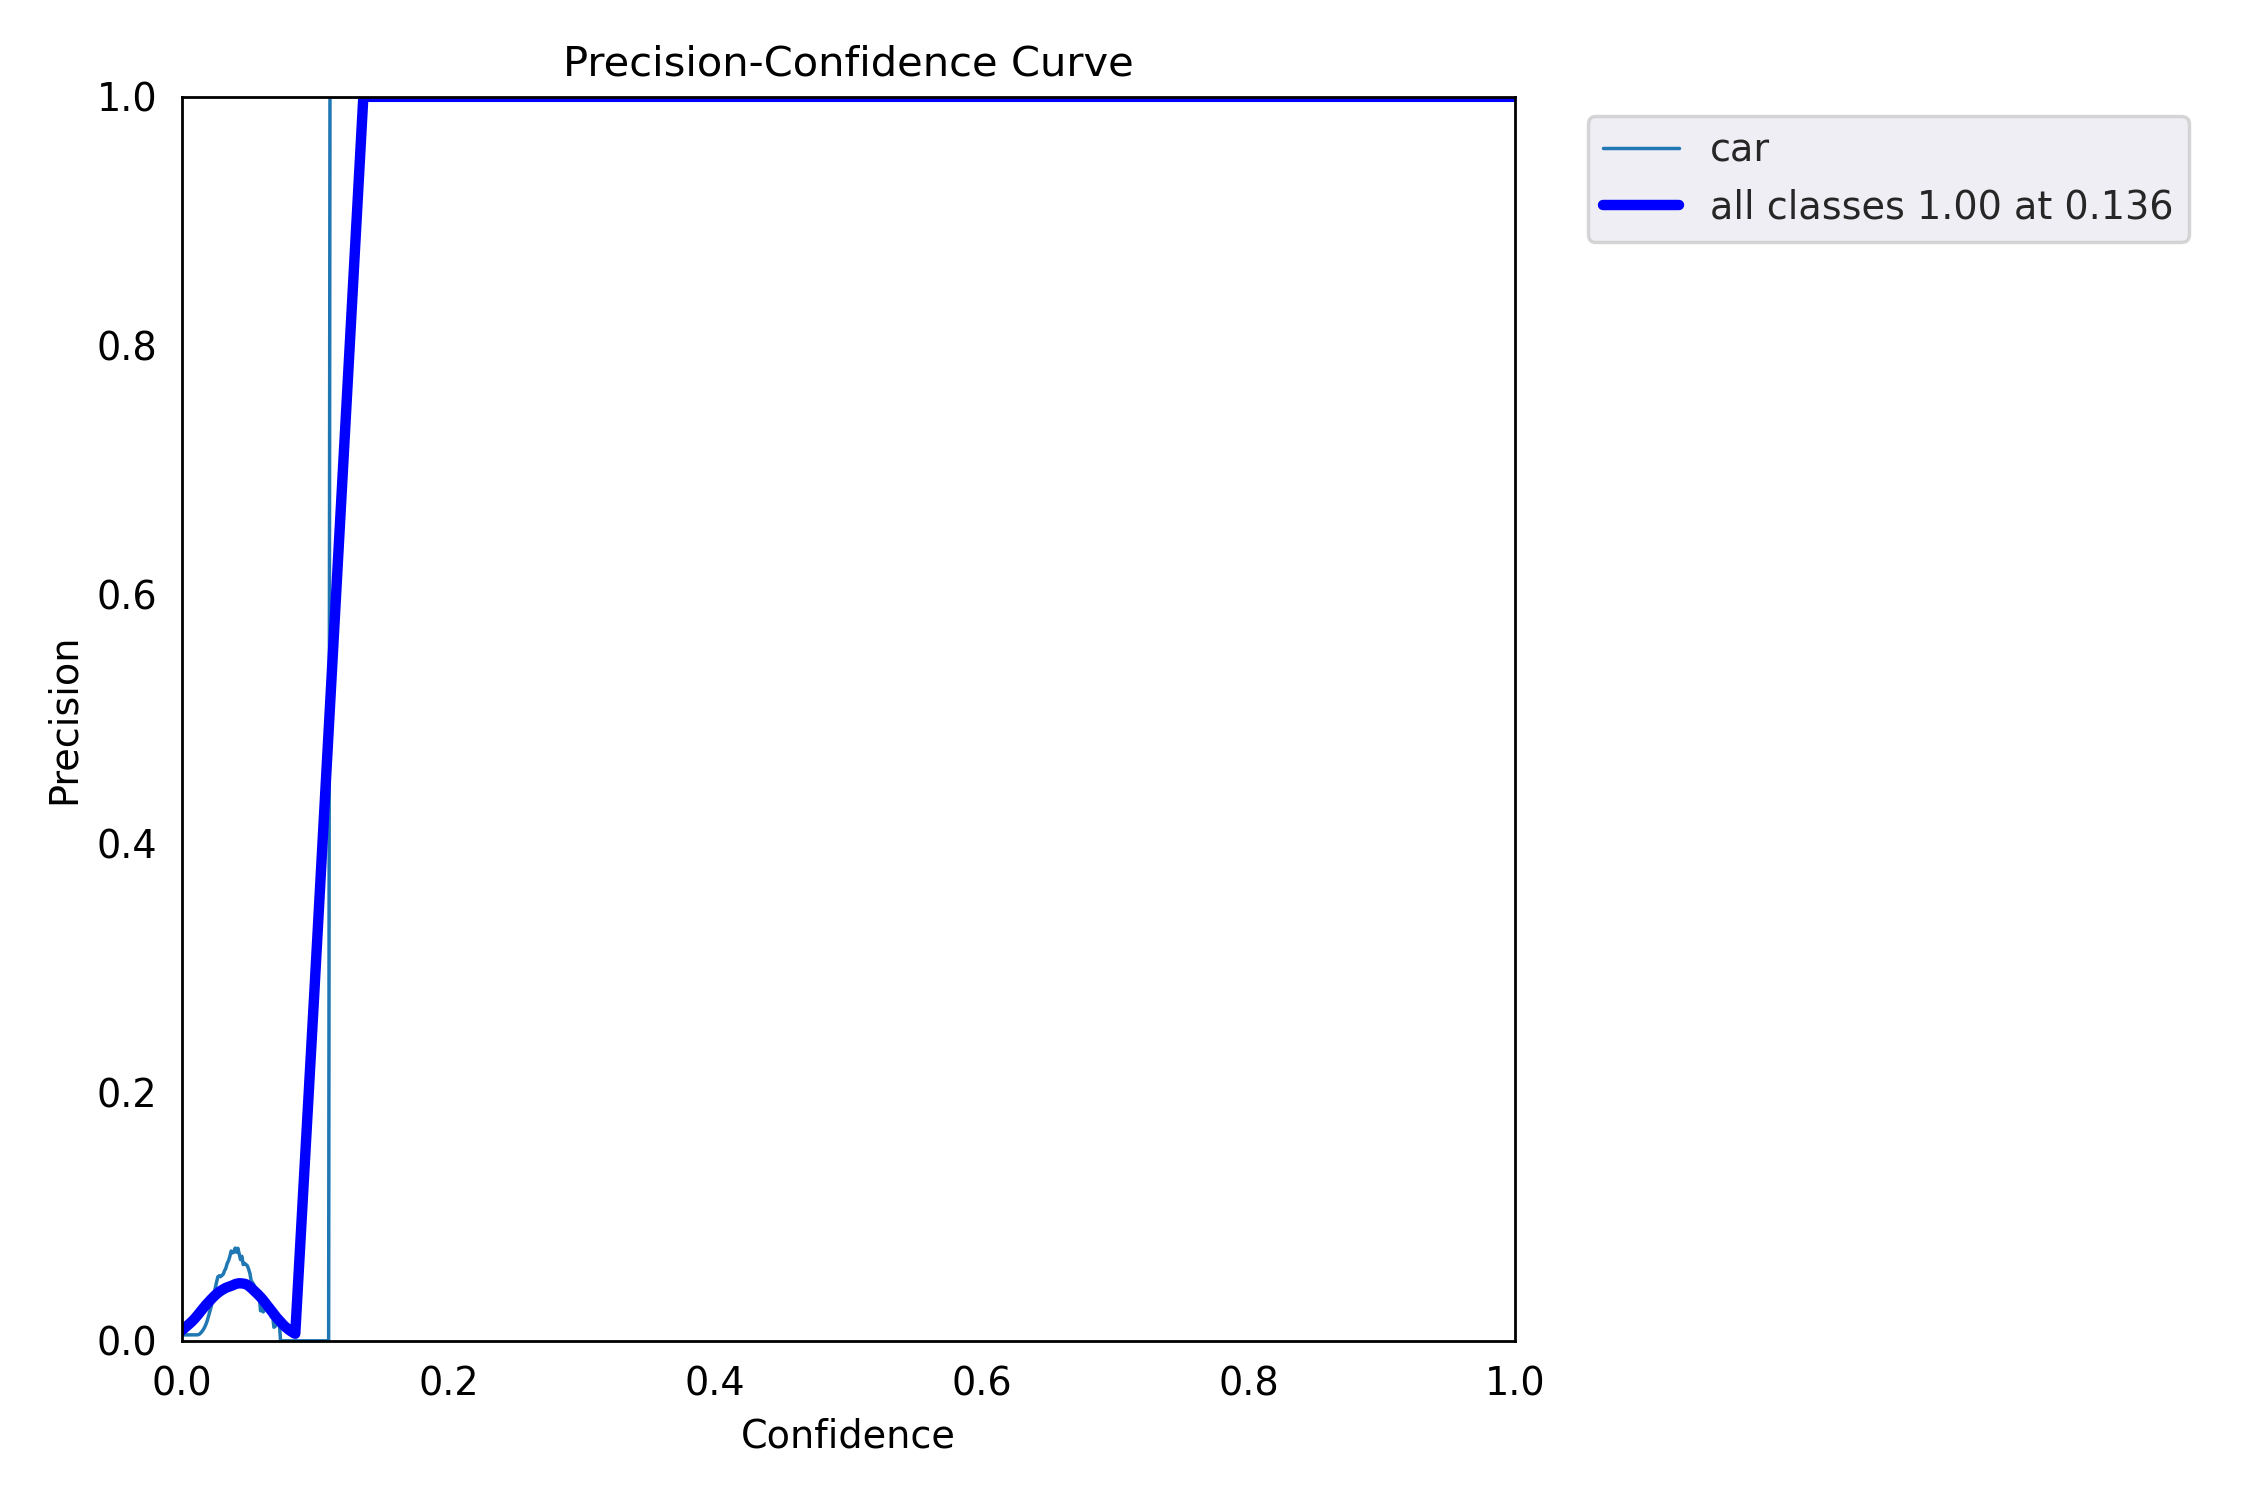

In [19]:
Image.open("yolov5/runs/train/my_model_5x/P_curve.png")

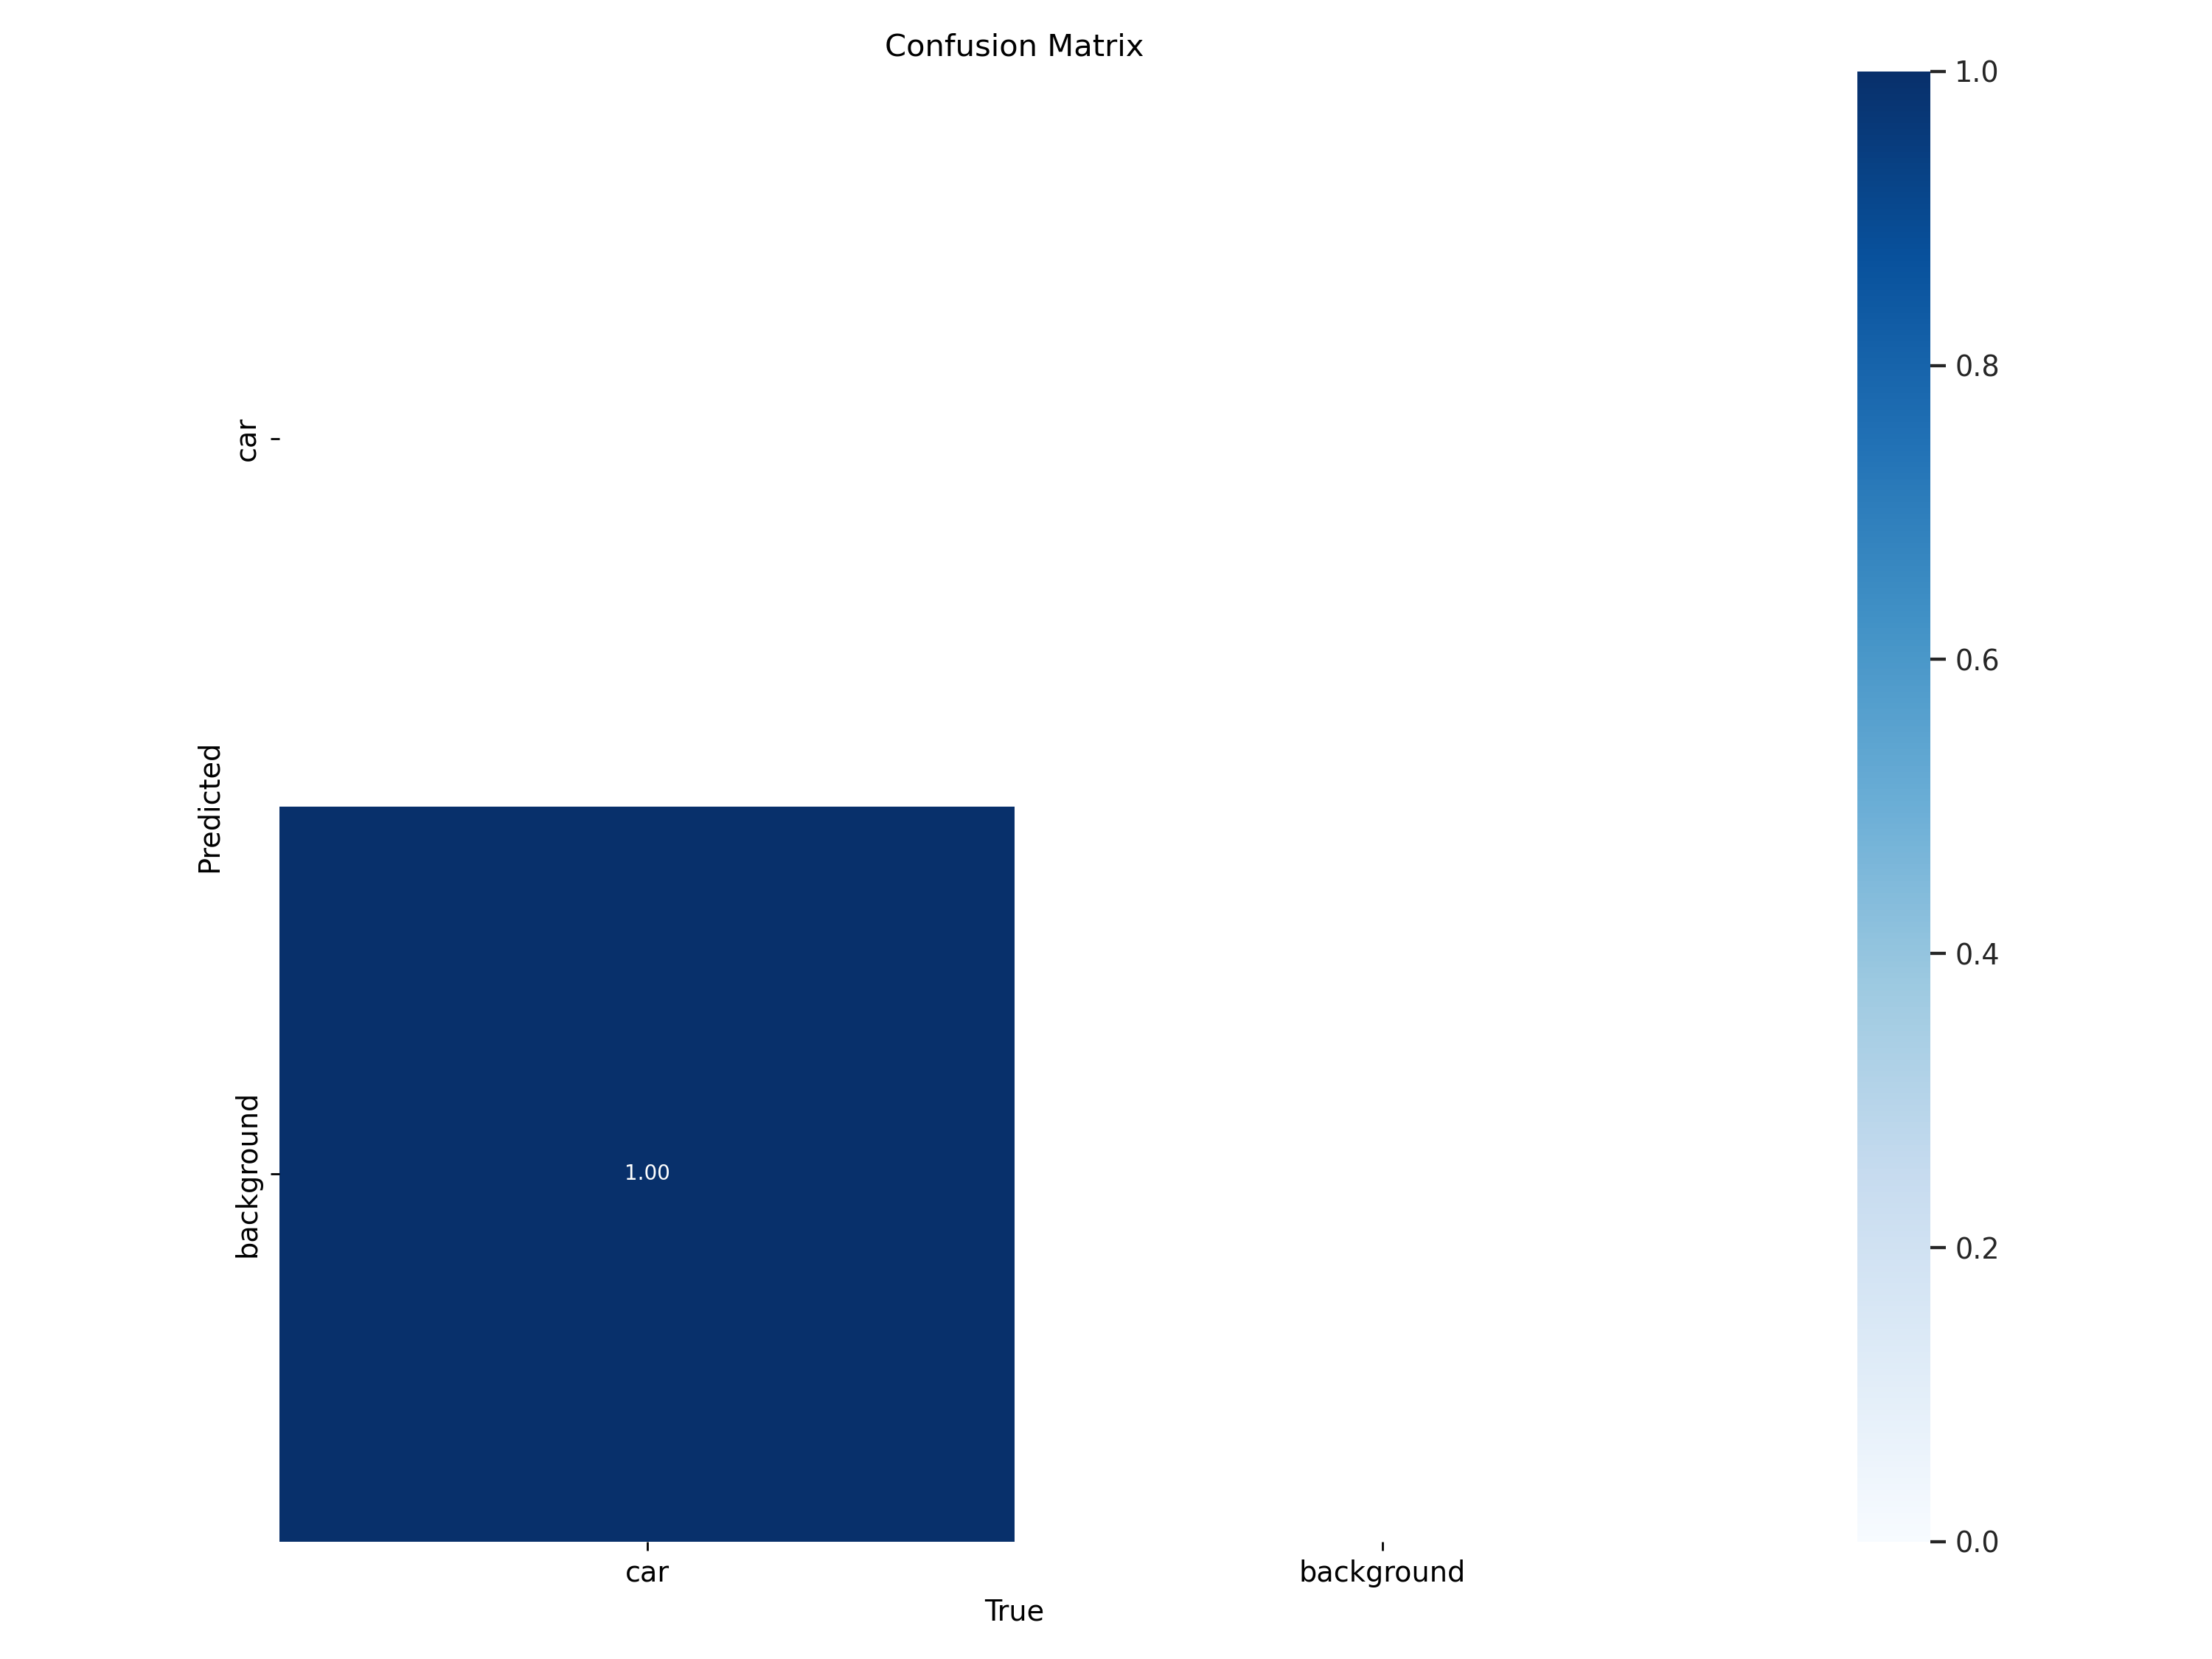

In [20]:
Image.open("yolov5/runs/train/my_model_5x/confusion_matrix.png")

# Detecting cars on test images

We are now going to use our custom trained model to detect cars on our testing images. The wieghts of our train model are inside "yolov5/runs/train/my_model_5x/weights/best.pt".

In [21]:
!python ./yolov5/detect.py --img {IMG_SIZE} --conf {CONF_TRESHOLD} --iou-thres {IOU_THRESHOLD} --source {test_dir} --weights yolov5/runs/train/my_model_5x/weights/best.pt

detect: weights=['yolov5/runs/train/my_model_5x/weights/best.pt'], source=/kaggle/input/car-object-detection/data/testing_images/, data=yolov5/data/coco128.yaml, imgsz=[676, 676], conf_thres=0.6, iou_thres=0.5, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
requirements: YOLOv5 requirement "tqdm>=4.64.0" not found, attempting AutoUpdate...

requirements: 1 package updated per /kaggle/working/yolov5/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

YOLOv5 🚀 v7.0-120-g3e55763 Python-3.7.12 torch-1.13.0 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 322 layers, 86173414 parameters, 0 gradients, 203.8 GFLOPs
WARNING ⚠️ --img-size [676, 676] must be multipl

In [22]:
!ls yolov5/runs/detect/exp/

vid_5_25100.jpg  vid_5_27460.jpg  vid_5_28540.jpg  vid_5_30640.jpg
vid_5_25120.jpg  vid_5_27480.jpg  vid_5_28560.jpg  vid_5_30660.jpg
vid_5_25140.jpg  vid_5_27500.jpg  vid_5_28580.jpg  vid_5_30680.jpg
vid_5_25160.jpg  vid_5_27520.jpg  vid_5_28600.jpg  vid_5_30700.jpg
vid_5_25180.jpg  vid_5_27540.jpg  vid_5_28620.jpg  vid_5_30720.jpg
vid_5_25200.jpg  vid_5_27560.jpg  vid_5_28640.jpg  vid_5_30740.jpg
vid_5_25220.jpg  vid_5_27580.jpg  vid_5_28660.jpg  vid_5_30760.jpg
vid_5_25240.jpg  vid_5_27600.jpg  vid_5_28680.jpg  vid_5_30820.jpg
vid_5_25260.jpg  vid_5_27620.jpg  vid_5_28700.jpg  vid_5_30840.jpg
vid_5_26320.jpg  vid_5_27640.jpg  vid_5_29000.jpg  vid_5_30860.jpg
vid_5_26400.jpg  vid_5_27660.jpg  vid_5_29020.jpg  vid_5_30920.jpg
vid_5_26420.jpg  vid_5_27680.jpg  vid_5_29040.jpg  vid_5_30940.jpg
vid_5_26560.jpg  vid_5_27700.jpg  vid_5_29060.jpg  vid_5_31020.jpg
vid_5_26580.jpg  vid_5_27720.jpg  vid_5_29080.jpg  vid_5_31040.jpg
vid_5_26600.jpg  vid_5_27740.jpg  vid_5_29100.jpg  vid_5_31060

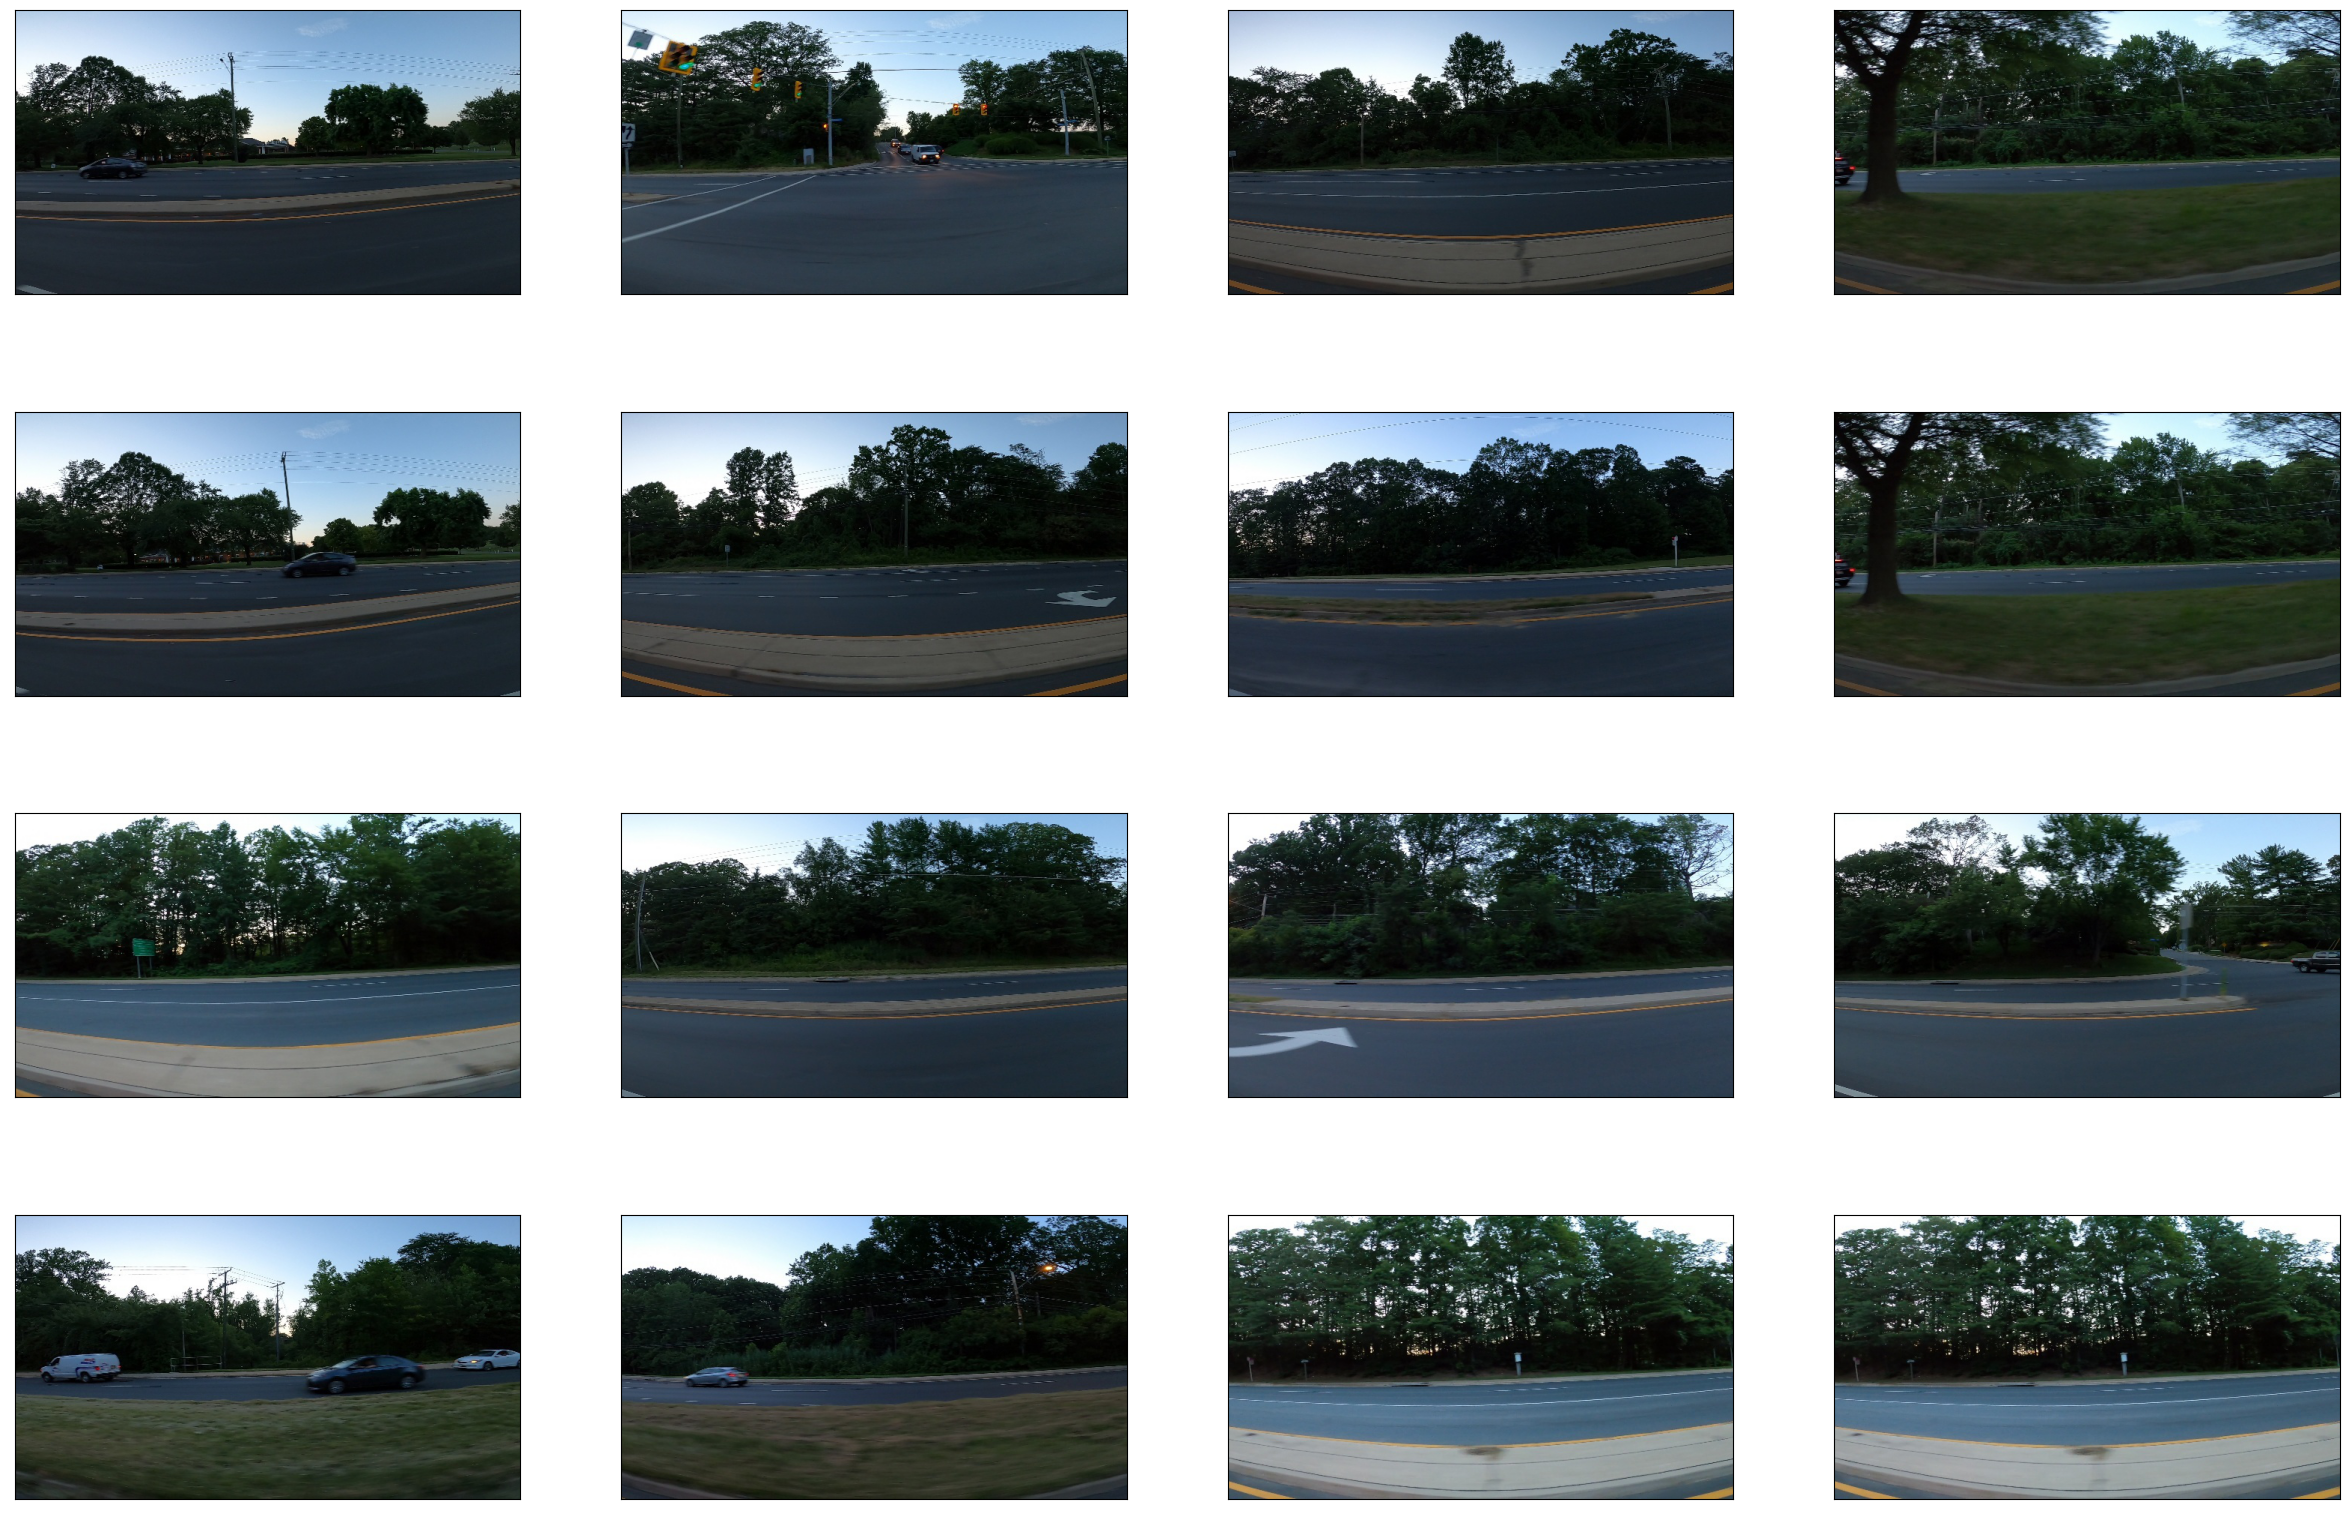

In [23]:
pred_dir = './yolov5/runs/detect/exp'
file_paths = []
flist = os.listdir(pred_dir)
for file in flist:
    fpath = os.path.join(pred_dir, file)
    file_paths.append(fpath)

plt.figure(figsize=(30, 20))
for i in range(16):
    random = np.random.randint(0, len(file_paths) - 1)
    plt.subplot(4, 4, i + 1)
    img_path = file_paths[random]
    img = plt.imread(img_path)
    plt.imshow(img)
    #plt.title('Predictions', size=10, color="black") 
    plt.xticks([])
    plt.yticks([])
    
plt.show()